In [1]:
import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
print(os.listdir("./input/chest_xray/chest_xray"))

['chest_xray', 'test', 'train', 'val', '__MACOSX']


In [11]:
print(os.listdir("./input/chest_xray/chest_xray/train/"))

['NORMAL', 'PNEUMONIA']


In [2]:
TRAIN_DIR = "./input/chest_xray/chest_xray/train/"
TEST_DIR =  "./input/chest_xray/chest_xray/test/"
VAL_DIR = "./input/chest_xray/chest_xray/val/"

In [4]:
def get_label(Dir):
    for nextdir in os.listdir(Dir):
        if not nextdir.startswith('.'):
            if nextdir in ['NORMAL']:
                label = 0
            elif nextdir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
    return nextdir, label

In [5]:
def preprocessing_data(Dir):
    X = []
    y = []
    
    for nextdir in os.listdir(Dir):
        nextdir, label = get_label(Dir)
        temp = Dir + nextdir
        
        for image_filename in tqdm(os.listdir(temp)):
            path = os.path.join(temp + '/' , image_filename)
            img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = skimage.transform.resize(img, (150, 150, 3))
                img = np.asarray(img)
                X.append(img)
                y.append(label)
            
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X,y

In [3]:
def get_data(Dir):
    X = []
    y = []
    for nextDir in os.listdir(Dir):
        if not nextDir.startswith('.'):
            if nextDir in ['NORMAL']:
                label = 0
            elif nextDir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
                
            temp = Dir + nextDir
                
            for file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file)
                if img is not None:
                    img = skimage.transform.resize(img, (150, 150, 3))
                    #img_file = scipy.misc.imresize(arr=img_file, size=(299, 299, 3))
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [7]:
X_train, y_train = get_data(TRAIN_DIR)

100%|██████████| 3875/3875 [09:45<00:00,  6.62it/s]


In [8]:
X_test , y_test = get_data(TEST_DIR)

100%|██████████| 390/390 [00:55<00:00,  6.99it/s]


In [4]:
X_val , y_val = get_data(VAL_DIR)

100%|██████████| 8/8 [00:01<00:00,  7.79it/s]


In [9]:
print(X_train.shape,'\n',X_test.shape)



(5216, 150, 150, 3) 
 (624, 150, 150, 3)


In [10]:
print(y_train.shape,'\n',y_test.shape)

(5216,) 
 (624,)


In [12]:
print(X_val.shape,'\n',y_val.shape)

(16, 150, 150, 3) 
 (16,)


In [11]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

Using TensorFlow backend.


In [12]:
Pimages = os.listdir(TRAIN_DIR + "PNEUMONIA")
Nimages = os.listdir(TRAIN_DIR + "NORMAL")

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


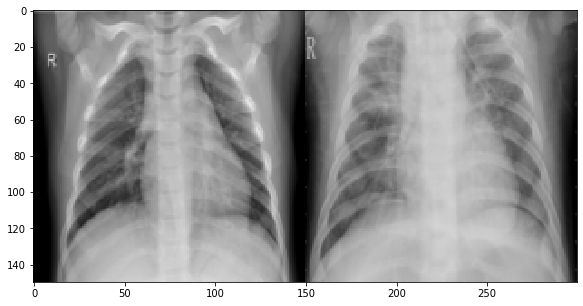

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


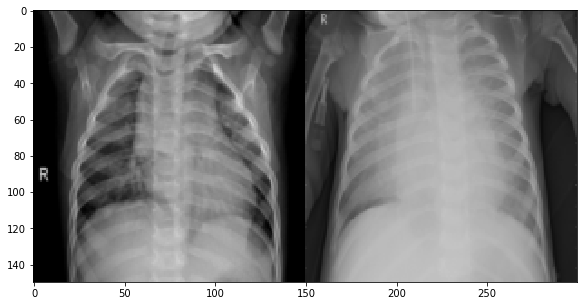

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


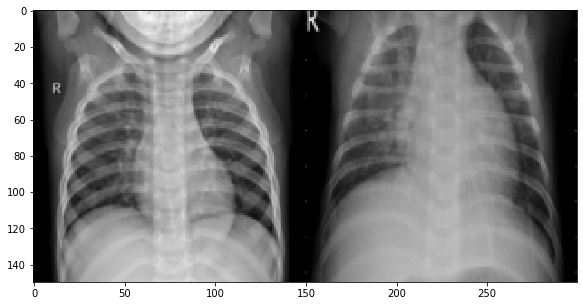

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


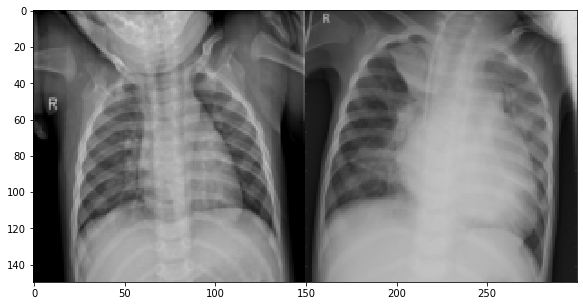

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


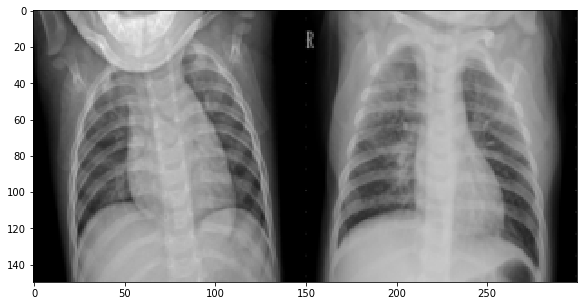

In [13]:
import matplotlib.pyplot as plt
def plotter(i):
    imagep1 = cv2.imread(TRAIN_DIR+"PNEUMONIA/"+Pimages[i])
    imagep1 = skimage.transform.resize(imagep1, (150, 150, 3) , mode = 'reflect')
    imagen1 = cv2.imread(TRAIN_DIR+"NORMAL/"+Nimages[i])
    imagen1 = skimage.transform.resize(imagen1, (150, 150, 3))
    pair = np.concatenate((imagen1, imagep1), axis=1)
    print("(Left) - No Pneumonia Vs (Right) - Pneumonia")
    print("-----------------------------------------------------------------------------------------------------------------------------------")
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
for i in range(5,10):
    plotter(i)

In [14]:
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint , LearningRateScheduler
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

C:\Users\Navin Stark\anaconda3\envs\dl\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [15]:
filepath="transferlearning_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [16]:
from keras.models import Sequential , Model
from keras.layers import Dense , Activation
from keras.layers import Dropout , GlobalAveragePooling2D
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop , Adadelta , Adam
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.common.set_image_dim_ordering('th')
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [17]:
X_train=X_train.reshape(5216,150,150,3)
X_test=X_test.reshape(624,150,150,3)

In [18]:
from keras.applications.inception_v3 import InceptionV3


In [19]:
base_model = InceptionV3(weights=None, include_top=False , input_shape=(150, 150,3))

In [20]:
x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(2, activation='sigmoid')(x)

In [21]:
base_model.load_weights("./input/inceptionweights/inception_v3_weights.h5")

In [22]:
model = Model(inputs=base_model.input, outputs=predictions)

In [23]:
model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

In [24]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [25]:
batch_size = 64
epochs = 10

In [26]:
history = model.fit(X_train, y_train, validation_data = (X_test , y_test) ,callbacks=[lr_reduce,checkpoint] ,
          epochs=epochs)

Train on 5216 samples, validate on 624 samples
Epoch 1/10
5216/5216 [==============================] - 1268s 243ms/step - loss: 0.1383 - accuracy: 0.9469 - val_loss: 1.2082 - val_accuracy: 0.7356


C:\Users\Navin Stark\anaconda3\envs\dl\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
C:\Users\Navin Stark\anaconda3\envs\dl\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/10
5216/5216 [==============================] - 1071s 205ms/step - loss: 0.0685 - accuracy: 0.9760 - val_loss: 0.2134 - val_accuracy: 0.9247
Epoch 3/10
5216/5216 [==============================] - 1055s 202ms/step - loss: 0.0472 - accuracy: 0.9826 - val_loss: 0.3241 - val_accuracy: 0.8862
Epoch 4/10
5216/5216 [==============================] - 1072s 206ms/step - loss: 0.0388 - accuracy: 0.9858 - val_loss: 0.9438 - val_accuracy: 0.8574
Epoch 5/10
5216/5216 [==============================] - 1053s 202ms/step - loss: 0.0280 - accuracy: 0.9908 - val_loss: 0.5709 - val_accuracy: 0.8878
Epoch 6/10
5216/5216 [==============================] - 1041s 200ms/step - loss: 0.0249 - accuracy: 0.9902 - val_loss: 0.7898 - val_accuracy: 0.8093
Epoch 7/10
5216/5216 [==============================] - 1070s 205ms/step - loss: 0.0436 - accuracy: 0.9831 - val_loss: 1.0073 - val_accuracy: 0.7324
Epoch 8/10
5216/5216 [==============================] - 1085s 208ms/step - loss: 0.0282 - accuracy: 0.9902

In [28]:
model.save("./saved_pnemonia_transferv3_learning.h5")
print("Model Saved")

Model Saved
